In [1]:
## INSTALL IF YOU DON'T HAVE SURPRISE ON YOUR MACHINE AND WOULD LIKE TO RUN THE CODE
#!pip install surprise
#!pip install import-ipynb

In [2]:
import os
import csv
import pandas as pd
import numpy as np
import heapq
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD
from surprise import dataset, KNNBaseline, accuracy
from surprise.model_selection import cross_validate
import pickle
from random import *
from surprise import accuracy
from collections import defaultdict
from surprise import KNNBasic
from collections import defaultdict
from operator import itemgetter
import NetflixLoadData as NetflixLoadData

# Explanation

# Notebook

In [3]:
use_pickle_file = True
max_n = 2500000 #how many rows we want from data_ratings and data_rating_plus_movie_title
reader = Reader(line_format='user item rating', rating_scale=(1, 5))

def save_to_pickle(name, df):
    path_name = "pickle/"+name+".pickle"
    pickle_file = open(path_name,"wb")
    pickle.dump(df, pickle_file)
    pickle_file.close()

def load_pickle(name):
    path_name = "pickle/"+name+".pickle"
    return_input = open(path_name, "rb")
    return pickle.load(return_input)

## Get data

In [4]:
data_movies, data_rating, data_rating_plus_movie_title, _ = NetflixLoadData.get_data_files(use_small_dataset=True)

In [5]:
data_rating

,movie_id,customer_id,rating
0,1,1488844,3.0
1,1,822109,5.0
2,1,885013,4.0
3,1,30878,4.0
4,1,823519,3.0
...,...,...,...
813413,4499,101554,4.0
813414,4499,1334851,3.0
813415,4499,1852040,1.0
813416,4499,185372,1.0


## Finding information about the data

In [6]:
import MovieCustomerInformation as information
max_rating = 4
min_rating = 4

### Details about all customers/movies

#### finding out size of the data being used

In [7]:
print("number of customers")
number_of_customers =  len(information.all_average_ratings(df=data_rating, type='customer_id')['customer_id'])
print(number_of_customers)

print(len(data_rating["customer_id"].unique()))

number of customers
4829
4829


In [8]:
number_of_movies = len(information.all_average_ratings(df=data_rating, type='movie_id')['movie_id'])
print("Number of movies rated", number_of_movies)
print("Total movies in dataset", len(data_movies["movie_id"].unique()))

Number of movies rated 4499
Total movies in dataset 17770


#### average rating

In [9]:
customer_average_rating = information.all_average_ratings(df=data_rating, type='customer_id')["avg_rating"].mean()
print("All customers average ratings", customer_average_rating)

All customers average ratings 3.5321404327111


In [10]:
movie_average_rating = information.all_average_ratings(df=data_rating, type='movie_id')['avg_rating'].mean()
print("All movies average ratings", movie_average_rating)

All movies average ratings 2.7833812231234294


In [11]:
# get the average movie rating for all customers
# used to determine if this user typically gives bad or good reviews
# and then we can see if he really hates or loves a movie
all_customers_average_ratings =  information.all_average_ratings(df=data_rating, type='customer_id')
## sort by how many ratings person has given (rating count)
print("Average rating for all customers (sorted by count)")
print(all_customers_average_ratings.sort_values(by=[('rating', 'count')], ascending=False))

Average rating for all customers (sorted by count)
     customer_id   rating       avg_rating
                      sum count           
549       305344   8464.0  4467   1.894784
727       387418   8079.0  4422   1.827001
4425     2439493   4973.0  4195   1.185459
3049     1664010  17104.0  4019   4.255785
3861     2118461  15390.0  3769   4.083311
...          ...      ...   ...        ...
870       470861      5.0     1   5.000000
1731      931793      5.0     1   5.000000
3953     2176039      3.0     1   3.000000
368       196497      5.0     1   5.000000
3652     1989766      4.0     1   4.000000

[4829 rows x 4 columns]


In [12]:
all_movies_average_rating = information.all_average_ratings(df=data_rating, type='movie_id')
## sort by how many ratings movie has (rating count)
print("Average rating for all movies (sorted by count)")
print(all_movies_average_rating.sort_values(by=[('rating', 'count')], ascending=False))

Average rating for all movies (sorted by count)
     movie_id   rating       avg_rating
                   sum count           
1904     1905  11738.0  3030   3.873927
570       571  12222.0  3021   4.045680
2451     2452  11777.0  2736   4.304459
4305     4306  10877.0  2642   4.116957
2861     2862  11235.0  2638   4.258908
...       ...      ...   ...        ...
1140     1141      7.0     4   1.750000
4293     4294     15.0     4   3.750000
886       887     14.0     4   3.500000
2536     2537      3.0     2   1.500000
4372     4373      1.0     1   1.000000

[4499 rows x 4 columns]


In [13]:
print("As seen as seen here below customer with customer_id = 305344 (which is the top rater) is in 4 out of 5 of the lowest rated movies,")
print("this shows that he could be responsible for many of the items having a low score in the data.")
print(data_rating[data_rating["movie_id"] == 4373])
print(data_rating[data_rating["movie_id"] == 2537])
print(data_rating[data_rating["movie_id"] == 887])
print(data_rating[data_rating["movie_id"] == 4294])
print(data_rating[data_rating["movie_id"] == 1141])

As seen as seen here below customer with customer_id = 305344 (which is the top rater) is in 4 out of 5 of the lowest rated movies,
this shows that he could be responsible for many of the items having a low score in the data.
        movie_id  customer_id  rating
789920      4373       305344     1.0
        movie_id  customer_id  rating
457875      2537       199769     2.0
457876      2537       305344     1.0
        movie_id  customer_id  rating
166319       887      1314869     3.0
166320       887      1899913     3.0
166321       887      2086129     3.0
166322       887       908626     5.0
        movie_id  customer_id  rating
769926      4294      2536523     5.0
769927      4294       721369     4.0
769928      4294       984703     5.0
769929      4294       305344     1.0
        movie_id  customer_id  rating
206926      1141      1471238     3.0
206927      1141       305344     1.0
206928      1141      2056022     2.0
206929      1141       387418     1.0


#### rating (low/high)

In [14]:
customer_ratings_low = information.get_avg_rating_less_than(df=all_customers_average_ratings , max_rating=max_rating)
print("Showing customers with scores lower than ", max_rating)
customer_ratings_low

Showing customers with scores lower than  4


customer_id  rating       avg_rating
                     sum count           
2            967    87.0    24   3.625000
3           1333  2007.0   750   2.676000
4           2442   404.0   118   3.423729
5           3321  2718.0  1062   2.559322
7           3718   529.0   175   3.022857
...          ...     ...   ...        ...
4824     2646591   163.0    51   3.196078
4825     2647871   814.0   248   3.282258
4826     2648122   306.0    85   3.600000
4827     2648650    83.0    27   3.074074
4828     2648861   181.0    53   3.415094

[4039 rows x 4 columns]

In [15]:
customer_ratings_high = information.get_avg_rating_higher_than(df=all_customers_average_ratings, min_rating=min_rating)
print("Showing customers with scores higher (or equal) to ", min_rating)
customer_ratings_high

Showing customers with scores higher (or equal) to  4


customer_id  rating       avg_rating
                     sum count           
0            685   124.0    30   4.133333
1            915    30.0     7   4.285714
6           3417   165.0    41   4.024390
12          5225   108.0    26   4.153846
18          8117  1062.0   260   4.084615
...          ...     ...   ...        ...
4800     2632269   103.0    25   4.120000
4804     2634414    33.0     8   4.125000
4806     2635437   499.0   115   4.339130
4807     2635895   314.0    75   4.186667
4814     2640085   158.0    34   4.647059

[721 rows x 4 columns]

In [16]:
print("number of rows in low", len(customer_ratings_low))
print("number of rows in high", len(customer_ratings_high))

number of rows in low 4039
number of rows in high 721


In [17]:
customers_low_high_ratings_percentage = ((len(customer_ratings_high)-len(customer_ratings_low)) / len(customer_ratings_low))*100
if(customers_low_high_ratings_percentage <= 0):
    print("high rating dataframe is " , round(customers_low_high_ratings_percentage, 2),'% smaller than low rating dataframe')

if(customers_low_high_ratings_percentage > 0):
    print("high rating dataframe is " , round(customers_low_high_ratings_percentage, 2),'% bigger than low rating dataframe')

high rating dataframe is  -82.15 % smaller than low rating dataframe


#### average rating (low/high)

In [18]:
print("Movies with avg_rating score less than ", max_rating)
information.get_avg_rating_less_than(df=all_movies_average_rating, max_rating=max_rating)

Movies with avg_rating score less than  4


movie_id  rating       avg_rating
                  sum count           
0           1  2051.0   547   3.749543
1           2   516.0   145   3.558621
2           3  7326.0  2012   3.641153
3           4   389.0   142   2.739437
4           5  4468.0  1140   3.919298
...       ...     ...   ...        ...
4494     4495   162.0    60   2.700000
4495     4496  2676.0   713   3.753156
4496     4497   220.0    84   2.619048
4497     4498    88.0    36   2.444444
4498     4499   230.0    83   2.771084

[4457 rows x 4 columns]

In [19]:
print("Movies with avg_rating score higher (or equal) to ", min_rating)
information.get_avg_rating_higher_than(df=all_movies_average_rating, min_rating=min_rating)

Movies with avg_rating score higher (or equal) to  4


movie_id   rating       avg_rating
                   sum count           
12         13     38.0     8   4.750000
222       223   3594.0   875   4.107429
240       241   5359.0  1317   4.069096
570       571  12222.0  3021   4.045680
752       753     33.0     8   4.125000
871       872   5000.0  1206   4.145937
885       886   7719.0  1918   4.024505
1019     1020   3501.0   842   4.157957
1255     1256    925.0   227   4.074890
1475     1476   1936.0   447   4.331096
1624     1625   5149.0  1258   4.093005
1914     1915    456.0   113   4.035398
2101     2102   1714.0   384   4.463542
2141     2142     49.0    11   4.454545
2161     2162   1919.0   471   4.074310
2171     2172   3516.0   811   4.335388
2429     2430   5708.0  1399   4.080057
2451     2452  11777.0  2736   4.304459
2462     2463    206.0    51   4.039216
2607     2608    474.0   116   4.086207
2699     2700    763.0   185   4.124324
2742     2743   6786.0  1695   4.003540
2781     2782   9395.0  2320   4.049569
2861     2862  11235.0  2638   4.258908
3045     3046   2610.0   610   4.278689
3289     3290   8399.0  1937   4.336087
3443     3444   1695.0   392   4.323980
3445     3446   4694.0  1161   4.043066
3455     3456    872.0   191   4.565445
3604     3605   7545.0  1850   4.078378
3863     3864   5176.0  1252   4.134185
3927     3928   1024.0   255   4.015686
3961     3962  10408.0  2465   4.222312
4114     4115    973.0   239   4.071130
4128     4129    101.0    25   4.040000
4206     4207   1204.0   296   4.067568
4305     4306  10877.0  2642   4.116957
4352     4353   2027.0   491   4.128310

In [20]:
print("count of ratings by each user")
print(all_customers_average_ratings[[('customer_id',''),('rating', 'count')]].sort_values(('rating', 'count'), ascending=False))

count of ratings by each user
     customer_id rating
                  count
549       305344   4467
727       387418   4422
4425     2439493   4195
3049     1664010   4019
3861     2118461   3769
...          ...    ...
870       470861      1
1731      931793      1
3953     2176039      1
368       196497      1
3652     1989766      1

[4829 rows x 2 columns]


find customers who rated a random movie

In [21]:
movie_to_find = data_movies['movie_title'][randrange(1000)]
information.get_customers_who_rated_movie_title(movie_title=movie_to_find)

,movie_id,customer_id,rating,movie_year,movie_title
27705,172,303948,3.0,2003.0,Jack
27706,172,402377,3.0,2003.0,Jack
27707,172,914338,2.0,2003.0,Jack
27708,172,1314869,2.0,2003.0,Jack
27709,172,428831,2.0,2003.0,Jack
...,...,...,...,...,...
56217,305,1403184,3.0,1996.0,Jack
56218,305,1795694,3.0,1996.0,Jack
56219,305,2634967,1.0,1996.0,Jack
56220,305,1400108,1.0,1996.0,Jack


In [22]:
information.get_avg_rating_for_movie_title(movie_title=movie_to_find)

movie_id rating       avg_rating movie_id                       
                sum count            movie_id movie_year movie_title
171      172   84.0    36   2.333333      172     2003.0        Jack

finding customers who rated a specific movie

In [23]:

information.get_customers_who_rated_movie_title(movie_title="Harold and Kumar Go to White Castle")

,movie_id,customer_id,rating,movie_year,movie_title
51402,290,1436762,4.0,2004.0,Harold and Kumar Go to White Castle
51403,290,1745265,5.0,2004.0,Harold and Kumar Go to White Castle
51404,290,1176140,2.0,2004.0,Harold and Kumar Go to White Castle
51405,290,439011,5.0,2004.0,Harold and Kumar Go to White Castle
51406,290,2632461,4.0,2004.0,Harold and Kumar Go to White Castle
...,...,...,...,...,...
52628,290,999312,5.0,2004.0,Harold and Kumar Go to White Castle
52629,290,520675,4.0,2004.0,Harold and Kumar Go to White Castle
52630,290,1550207,2.0,2004.0,Harold and Kumar Go to White Castle
52631,290,1424777,3.0,2004.0,Harold and Kumar Go to White Castle


In [24]:
information.get_avg_rating_for_movie_title(movie_title="Harold and Kumar Go to White Castle")

movie_id  rating       avg_rating movie_id             \
                 sum count            movie_id movie_year   
289      290  4351.0  1231   3.534525      290     2004.0   

                                          
                             movie_title  
289  Harold and Kumar Go to White Castle

In [25]:
def generate_random_user_ids(from_n, to_n):
    ids = np.unique(data_rating['customer_id'])[from_n:to_n]
    print("random user id used while in development\n")
    return ids
## use when developing the program and need new customer_ids
generate_random_user_ids(1000, 1500)

random user id used while in development



array([532439, 532649, 532710, 533381, 534018, 534046, 534152, 534777,
       535396, 536526, 537150, 538373, 538741, 539019, 539354, 539743,
       539791, 540794, 540807, 541826, 542027, 542345, 543865, 544022,
       544496, 544571, 544832, 544833, 545026, 545639, 546933, 547732,
       548064, 550170, 550777, 551208, 551817, 552356, 552997, 553632,
       553668, 553931, 555509, 555955, 556045, 556249, 556534, 556633,
       557801, 558634, 559021, 560851, 561184, 561923, 563237, 563607,
       563962, 564660, 565041, 565401, 565510, 565962, 568930, 569099,
       569386, 570522, 571700, 571702, 572124, 573330, 573434, 573537,
       573975, 573995, 574778, 574843, 575714, 575830, 575867, 576584,
       576763, 576990, 577547, 578237, 578632, 578699, 580784, 581199,
       582829, 582996, 584542, 584750, 584893, 586421, 586652, 586741,
       587259, 587685, 588344, 589596, 589626, 589682, 589967, 590113,
       590466, 591072, 591866, 592003, 592122, 592281, 592455, 592671,
      

### Details about a specific customer

In [26]:
# ids I like -> 28812, 56514, 56520, 1488844, 84100, 534046
customer_id_use = 534046

In [27]:
print("Movies/TV Shows user", customer_id_use, "has rated")
information.all_id_rows(df=data_rating_plus_movie_title, type="customer_id", item_id=customer_id_use)

Movies/TV Shows user 534046 has rated


,movie_id,customer_id,rating,movie_year,movie_title
3131,5,534046,5.0,2004.0,The Rise and Fall of ECW
8700,30,534046,5.0,2003.0,Something's Gotta Give
12247,52,534046,5.0,2002.0,The Weather Underground
31214,187,534046,3.0,2002.0,Death to Smoochy
34441,194,534046,4.0,1996.0,Arliss: The Best of Arliss
51683,290,534046,4.0,2004.0,Harold and Kumar Go to White Castle
111420,571,534046,4.0,1999.0,American Beauty
187786,1029,534046,1.0,1995.0,Tromeo and Juliet
210575,1148,534046,4.0,1981.0,For Your Eyes Only
289148,1642,534046,5.0,1995.0,Casino: 10th Anniversary Edition


In [28]:
print("User", customer_id_use, "stats (sum of all ratings, count of ratings, avg_rating)")
information.get_item_avg_rating(df=all_customers_average_ratings, type='customer_id', item_id=customer_id_use)

User 534046 stats (sum of all ratings, count of ratings, avg_rating)


customer_id rating       avg_rating
                    sum count           
1005      534046  113.0    28   4.035714

In [29]:
#display_movies_customer_rated_higher_than(customer_id=customer_id_use, min_rating=4)
print("Movies/TV Shows user", customer_id_use, "has rated higher (or equal) to", min_rating)
information.display_movies_customer_rated_higher_than(df=data_rating_plus_movie_title, customer_id=customer_id_use, min_rating=min_rating)

Movies/TV Shows user 534046 has rated higher (or equal) to 4
                                  movie_title  rating
movie_id                                             
5                    The Rise and Fall of ECW     5.0
30                     Something's Gotta Give     5.0
52                    The Weather Underground     5.0
194                Arliss: The Best of Arliss     4.0
290       Harold and Kumar Go to White Castle     4.0
571                           American Beauty     4.0
1148                       For Your Eyes Only     4.0
1642         Casino: 10th Anniversary Edition     5.0
1719       The Life Aquatic with Steve Zissou     5.0
1798                            Lethal Weapon     4.0
1843                    Beverly Hills Cop III     4.0
2178                                     Lock     4.0
2464                                 Trekkies     4.0
2782                               Braveheart     4.0
2862                 The Silence of the Lambs     5.0
2939              Mic

In [30]:
print("Movies/TV Shows user", customer_id_use, "has rated lower than", max_rating)
information.display_movies_customer_rated_lower_than(df= data_rating_plus_movie_title,customer_id=customer_id_use, max_rating=max_rating)

Movies/TV Shows user 534046 has rated lower than 4
                  movie_title  rating
movie_id                             
187          Death to Smoochy     3.0
1029        Tromeo and Juliet     1.0
1700            Bottle Rocket     3.0
1744        Beverly Hills Cop     3.0
2840      Fantasm Comes Again     1.0
average rating 1005    4.035714
Name: avg_rating, dtype: float64


In [31]:
print("(Results in this cell is the same as above but now shows clearer which movies/tv shows customer likes and which he hates)")
information.get_users_loved_hated_movies(df=data_rating_plus_movie_title, customer_id=customer_id_use, minmax_rating=4)

(Results in this cell is the same as above but now shows clearer which movies/tv shows customer likes and which he hates)
User 534046 loved these movies
The Rise and Fall of ECW
Something's Gotta Give
The Weather Underground
Arliss: The Best of Arliss
Harold and Kumar Go to White Castle
American Beauty
For Your Eyes Only
Casino: 10th Anniversary Edition
The Life Aquatic with Steve Zissou
Lethal Weapon
Beverly Hills Cop III
Lock
Trekkies
Braveheart
The Silence of the Lambs
Michael Moore Hates America
The Godfather
Lethal Weapon 3
Goldfinger
The People vs. Larry Flynt
Garden State
A Mighty Wind
Road to Perdition

and disliked these movies
Death to Smoochy
Tromeo and Juliet
Bottle Rocket
Beverly Hills Cop
Fantasm Comes Again


In [32]:
print("showing user", customer_id_use, "average_rating against all other users that have given a rating\n")
all_customers_avg_rating = all_customers_average_ratings["avg_rating"].mean()

usr = information.all_average_ratings(df=data_rating, type='customer_id')
usr = usr[usr["customer_id"] == 596533]

change = ((usr["avg_rating"] - all_customers_avg_rating) / all_customers_avg_rating)*100


print("average rating for user:", float(usr["avg_rating"]))
print("average rating for all users:", all_customers_avg_rating)
print("difference between them", round(float(change), 2), "%")

showing user 534046 average_rating against all other users that have given a rating

average rating for user: 4.571428571428571
average rating for all users: 3.5321404327111
difference between them 29.42 %


## Recommendations with collaborative filtering

See the file streamlit-app.py to visually see the recommendations, run by doing this line in a terminal ->
streamlit run streamlit-app.py

#### functions

In [33]:
from surprise import dataset, KNNBaseline, accuracy
from surprise.model_selection import train_test_split, LeaveOneOut

def get_drop_list(type="movie_id"):
    #>IF MOVIE:  movie_id, movie rating count, movie rating mean
    #>IF CUSTOMER: customer_id, custumer rating count, customer rating mean
    df_count_mean_summary = data_rating.groupby(type)['rating'].agg(['count', 'mean'])
    df_count_mean_summary.index = df_count_mean_summary.index.map(int)
    #>IF MOVIE: returns 1799.0 as a benchmark number
    #IF CUSTOMER: returns 52.0 as a benchmark number
    benchmark = round(df_count_mean_summary['count'].quantile(0.7),0)
    # drop all rows below benchmark
    df_drop_list = df_count_mean_summary[df_count_mean_summary['count'] < benchmark]
    # return all indexes to drop
    return df_drop_list

def get_customer_recommendations(customer_id, predictor):
    #> returns movie_id, movie_year, movie_title
    chosen_customer_pred = data_movies.copy()
    # fails if movie_id is the index so we have to reset the index back to normal (0-N)
    chosen_customer_pred = chosen_customer_pred.reset_index()
    # makes sure that we only pick movies that are not in the movie dropped list
    chosen_customer_pred = chosen_customer_pred[~chosen_customer_pred['movie_id'].isin(df_movie_drop_list)]
    # make prediction for customer with id = <customer_id> and put it into 'estimated_score'
    chosen_customer_pred['estimated_score'] = chosen_customer_pred['movie_id'].apply(lambda x: predictor.predict(customer_id, x).est)
    # sort by 'estimated score'
    chosen_customer_pred = chosen_customer_pred.sort_values('estimated_score', ascending=False).set_index('movie_id')
    return chosen_customer_pred

# print out movies/tv show user has previously rated
def display_rated_content(customer_id=customer_id_use, number_to_show=20):
    print("Movies/TV Shows rated by customer", customer_id)
    #df = all_customers_id_plus_movie_title_rows(customer_id=customer_id)
    df = information.all_id_rows(df=data_rating_plus_movie_title, type='customer_id', item_id=customer_id)
    df = df[['movie_title', 'rating']].sort_values('rating', ascending=False)
    print(df[0:number_to_show].set_index('movie_title'))

def display_customers_recommendations(customer_id=customer_id_use, df=[], number_to_show=20):
    print("Movies/TV Shows recommended to customer")
    tmp_df = df[['movie_title', 'estimated_score']][0:number_to_show]
    tmp_df = tmp_df.set_index('movie_title')
    print(tmp_df)

def display_recommendation(customer_id, number_to_show, predictor):
    chosen_customer_pred = get_customer_recommendations(customer_id=customer_id, predictor=predictor)
    display_customers_recommendations(customer_id=customer_id, df=chosen_customer_pred, number_to_show=number_to_show)

def print_evaluation_accuracy(predictions):
    print("\nEvaluating accuracy of model...")
    print("RMSE: ", accuracy.rmse(predictions, verbose=False))
    print("MSE: ", accuracy.mse(predictions, verbose=False))
    print("MAE: ", accuracy.mae(predictions, verbose=False))
    # FCP = Fraction of Concordant Pairs
    print("FCP: ", accuracy.mae(predictions, verbose=False))

#### create recommenders

In [34]:
## creating a list of the movies that we don't wanna include
df_movie_drop_list = get_drop_list(type="movie_id")
#df_customer_drop_list = get_summary(type="customer_id")

### algo 1

In [35]:
## creating a test function to see if there is any difference in creating a custom function or just use the default
# here is the default way
def test_against_our_custom_function():
    _, data_rating, _, _ = NetflixLoadData.get_data_files(use_small_dataset=True)
    dataset = Dataset.load_from_df(data_rating[['customer_id', 'movie_id', 'rating']], reader)
    fullTrainset = dataset.build_full_trainset()

    trainSet, testSet = train_test_split(dataset, test_size=.25, random_state=1)

    algo = SVD(random_state=10)
    algo.fit(trainSet)

    predictions = algo.test(testSet)
    print("\nEvaluating accuracy of model...")
    print("RMSE: ", accuracy.rmse(predictions, verbose=False))
    print("MSE: ", accuracy.mse(predictions, verbose=False))
    print("MAE: ", accuracy.mae(predictions, verbose=False))
    # FCP = Fraction of Concordant Pairs
    print("FCP: ", accuracy.mae(predictions, verbose=False))

#here is my custom function
class convert_to_raw_ratings(dataset.DatasetAutoFolds):
    def __init__(self, df, reader):
        self.raw_ratings = [(uid, iid, r, None) for (uid, iid, r) in zip(df['customer_id'], df['movie_id'], df['rating'])]

#raw_ratings = convert_to_raw_ratings(data_rating, reader)
#print("\nBuilding recommendation model...")
#trainSet, testSet = train_test_split(raw_ratings, test_size=.25, random_state=1)

#algo = SVD(random_state=10)
#algo.fit(trainSet)
#algo_predictions = algo.test(testSet)

#test_against_our_custom_function()
#print_evaluation_accuracy(algo_predictions)

In [36]:
#save_to_pickle("algorithm_svd", algo)
# #save_to_pickle("algo_raw_rating", raw_ratings)
# save_to_pickle("algo_trainSet", trainSet)
# save_to_pickle("algo_testSet", testSet)

### many different algorithms

In [37]:
dataset = Dataset.load_from_df(data_rating[['customer_id', 'movie_id', 'rating']], reader)
fullTrainset = dataset.build_full_trainset()
trainSet, testSet = train_test_split(dataset, test_size=.25, random_state=1)

In [38]:
data_rating.describe()

,movie_id,customer_id,rating
count,813418.000000,8.134180e+05,813418.000000
mean,2264.330207,1.318841e+06,3.286366
std,1315.797799,7.634273e+05,1.206194
min,1.000000,6.850000e+02,1.000000
25%,1116.000000,6.362620e+05,3.000000
50%,2282.000000,1.317671e+06,3.000000
75%,3406.000000,1.961619e+06,4.000000
max,4499.000000,2.648861e+06,5.000000


In [39]:
knn_basic = KNNBasic(K=40)
knn_basic.fit(trainSet)
knn_basic_predictions = knn_basic.test(testSet)
print_evaluation_accuracy(knn_basic_predictions)

Computing the msd similarity matrix...
Done computing similarity matrix.

Evaluating accuracy of model...
RMSE:  0.9905971347999022
MSE:  0.9812826834737757
MAE:  0.7873154069977992
FCP:  0.7873154069977992


In [40]:
#cross_validate(knn_basic, dataset, measures=['MSE', 'RMSE', 'MAE'], cv=3, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating MSE, RMSE, MAE of algorithm KNNBasic on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
MSE (testset)     1.0004  1.0025  1.0093  1.0041  0.0038  
RMSE (testset)    1.0002  1.0012  1.0046  1.0020  0.0019  
MAE (testset)     0.7954  0.7964  0.7991  0.7970  0.0015  
Fit time          18.88   21.00   20.66   20.18   0.93    
Test time         169.52  161.26  134.65  155.14  14.88   


{'test_mse': array([1.00037021, 1.00249634, 1.00930054]),
 'test_rmse': array([1.00018509, 1.00124739, 1.00463951]),
 'test_mae': array([0.79544185, 0.79642976, 0.7990663 ]),
 'fit_time': (18.88226866722107, 20.9967999458313, 20.658180236816406),
 'test_time': (169.51518630981445, 161.25828909873962, 134.65037059783936)}

## testing many different algorithms

In [43]:
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise import KNNBasic, KNNWithMeans, KNNWithZScore
from surprise import SVD, SVDpp, NMF
from surprise import SlopeOne, CoClustering

In [44]:
cv = 3
n_jobs = 3
data = dataset

trying below couple of algorithms that I found on the surprise documentation website ( https://surprise.readthedocs.io/en/stable/knn_inspired.html )

In [45]:
knn_basic_cv = cross_validate(KNNBasic(), data, cv=cv, n_jobs=n_jobs, verbose=False)
knn_means_cv = cross_validate(KNNWithMeans(), data, cv=cv, n_jobs=n_jobs, verbose=False)

In [46]:
svd_cv = cross_validate(SVD(), data, cv=cv, n_jobs=n_jobs, verbose=False)
#svdpp_cv = cross_validate(SVDpp(), data, cv=cv, n_jobs=n_jobs, verbose=False) # #Quit running after an hour since it had not finished#
nmf_cv = cross_validate(NMF(), data, cv=cv, n_jobs=n_jobs, verbose=False)

In [47]:
#svd_cv = cross_validate(SVD(), data, cv=cv, n_jobs=n_jobs, verbose=False)
#nmf_cv = cross_validate(NMF(), data, cv=cv, n_jobs=n_jobs, verbose=False) 

In [48]:
slope_cv = cross_validate(SlopeOne(), data, cv=cv, n_jobs=n_jobs, verbose=False)
coclus_cv = cross_validate(CoClustering(), data, cv=cv, n_jobs=n_jobs, verbose=False)

In [49]:
def display_results_algorithms(title, algorithm):
    #print()
    print(title, '\t', round(algorithm['test_rmse'].mean(), 2), '\t', round(algorithm['test_mae'].mean(), 2))

In [50]:
print('Algorithm\t RMSE\t\t MAE')
print()
display_results_algorithms('KNN Basic', knn_basic_cv)
display_results_algorithms('KNN Means', knn_means_cv)
print()
display_results_algorithms('SVD', svd_cv)
#display_results_algorithms('SVDpp', svdpp_cv) # after an hour I just quit running this since it had not finished
display_results_algorithms('NMF', nmf_cv)
print()
display_results_algorithms('SlopeOne', slope_cv)
display_results_algorithms('CoClustering', coclus_cv)

Algorithm	 RMSE		 MAE

KNN Basic 	 1.0 	 0.8
KNN Means 	 0.95 	 0.74

SVD 	 0.92 	 0.71
NMF 	 0.96 	 0.75

SlopeOne 	 0.96 	 0.75
CoClustering 	 0.96 	 0.74


In [66]:
def show_visually_best_performing(title, metric, label, color):
    font_size = 10
    x_axis_labels = ['KNN Basic', 'KNN Means', 'SVD', 'NMF', 'SlopeOne','CoClustering']
    plt.title(title, loc='center', fontsize=font_size)
    plt.plot(x_axis_labels, metric, label=label, color=color, marker='o')
    plt.xlabel('Algorithm comparison', fontsize=font_size)
    plt.ylabel("error score", fontsize=font_size)
    plt.legend()
    plt.grid(ls='dashed')


In [59]:
from statistics import mean
list_of_algorithms = [knn_basic_cv, knn_means_cv, svd_cv, nmf_cv, slope_cv, coclus_cv]
rmse_cv = [round(item['test_rmse'].mean(), 2) for item in list_of_algorithms]
mae_cv = [round(item['test_mae'].mean(), 2) for item in list_of_algorithms]


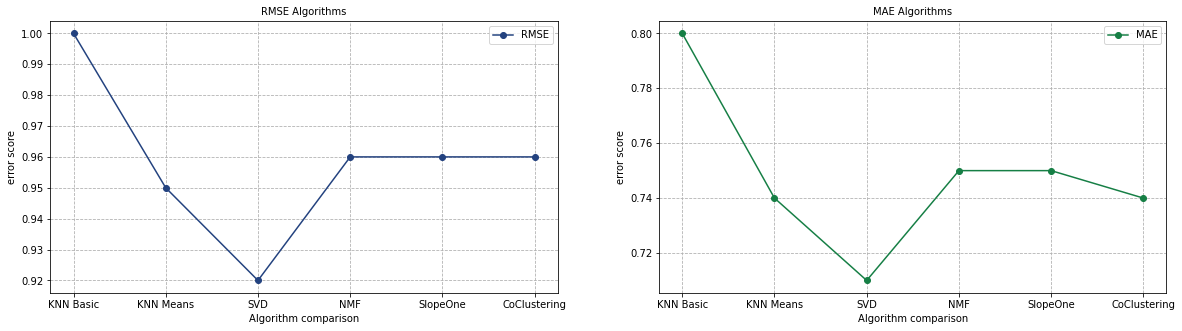

In [75]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
show_visually_best_performing(
    title="RMSE Algorithms", metric=rmse_cv, label="RMSE", color="#23427f")
plt.subplot(1, 2, 2)
show_visually_best_performing(
    title="MAE Algorithms", metric=mae_cv, label="MAE", color="#167f45")
plt.show()


choosing the two best algorithms to run through grid search

Linkur á surprise doc fyrir parameter grid https://surprise.readthedocs.io/en/v1.0.1/getting_started.html

In [76]:
cv = 3
n_jobs = 3

#svd
param_grid = {'n_epochs': [5, 10, 20],
              'lr_all': [0.002, 0.01],
              'reg_all': [0.4, 0.6]}

svd_grid = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=cv, n_jobs=n_jobs)
svd_grid.fit(data)

#knn
pram_grid_knn = {'k': [10, 20, 30, 40, 50]}
knn_with_means_grid = GridSearchCV(KNNWithMeans, pram_grid_knn, measures=['rmse', 'mae'], cv=cv, n_jobs=n_jobs)
knn_with_means_grid.fit(data)


In [82]:
print('Best params for SVD RMSE:', svd_grid.best_params['rmse'])
print('Best params for SVD MAE:', svd_grid.best_params['mae'])
print("")
print('Best params for KNN_WITH_MEANS RMSE:', knn_with_means_grid.best_params['rmse'])
print('Best params for KNN_WITH_MEANS MAE:', knn_with_means_grid.best_params['mae'])


Best params for SVD RMSE: {'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.4}
Best params for SVD MAE: {'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.4}

Best params for KNN_WITH_MEANS RMSE: {'k': 50}
Best params for KNN_WITH_MEANS MAE: {'k': 50}


In [94]:
best_svd_grid = SVD(**svd_grid.best_params['rmse'])
best_svd_grid.fit(trainSet)
predictions_best_svd_grid = best_svd_grid.test(testSet)

best_knn_with_means_grid = KNNWithMeans(**knn_with_means_grid.best_params['rmse'])
best_knn_with_means_grid.fit(trainSet)
prediction_best_knn_with_means_grid = best_knn_with_means_grid.test(testSet)


Computing the msd similarity matrix...
Done computing similarity matrix.


array([1488844,  822109,  885013, ...,  682051, 1550207, 1029867])

In [ ]:
## test
# for uid in data_rating['customer_id'].unique():
#     for iid in data_rating['movie_id'].unique():
#         est = best_svd_grid.predict(uid, iid).est
#         

[Prediction(uid=1452669, iid=4227, r_ui=2.0, est=3.2000838301458896, details={'was_impossible': False}),
 Prediction(uid=2446163, iid=798, r_ui=5.0, est=3.94182539696363, details={'was_impossible': False}),
 Prediction(uid=1012590, iid=1218, r_ui=4.0, est=3.3381062059963265, details={'was_impossible': False}),
 Prediction(uid=15420, iid=1102, r_ui=3.0, est=3.040836553873895, details={'was_impossible': False}),
 Prediction(uid=1777614, iid=1068, r_ui=3.0, est=3.095676170659499, details={'was_impossible': False}),
 Prediction(uid=518236, iid=2186, r_ui=3.0, est=3.5259032314554983, details={'was_impossible': False}),
 Prediction(uid=2151076, iid=4353, r_ui=5.0, est=4.19090809796221, details={'was_impossible': False}),
 Prediction(uid=305344, iid=3686, r_ui=3.0, est=2.0819423960629, details={'was_impossible': False}),
 Prediction(uid=2494005, iid=3138, r_ui=5.0, est=3.7518513914252143, details={'was_impossible': False}),
 Prediction(uid=371701, iid=28, r_ui=3.0, est=2.878888484986208, deta

### display recommendations

In [51]:
number_to_show = 10

#### customer = 79724

In [52]:
print("items user has rated before")
display_rated_content(customer_id=532649, number_to_show=number_to_show)

items user has rated before
Movies/TV Shows rated by customer 532649
                                          rating
movie_title                                     
Matewan                                      5.0
Black Orpheus                                5.0
Talk to Her                                  4.0
Alien: Collector's Edition                   4.0
Captain Pantoja and the Special Services     4.0
The Silence of the Lambs                     4.0
The Hustler                                  4.0
Y Tu Mama Tambien                            4.0
Quincy Jones: In the Pocket                  4.0
The Lower Depths (Donzoko)                   4.0


In [95]:
display_recommendation(customer_id=532649, number_to_show=number_to_show, predictor=predictions_best_svd_grid)


AttributeError: 'list' object has no attribute 'predict'

Recommendations based on previous svd algorithm since the code did not mange to be done before I had to submit.

In [55]:
display_recommendation(customer_id=532649, number_to_show=number_to_show, predictor=prediction_best_knn_with_means_grid)

AttributeError: 'dict' object has no attribute 'predict'

#### customer = customer_id_use

In [ ]:
print("items user has rated before")
display_rated_content(customer_id=customer_id_use, number_to_show=number_to_show)

In [ ]:
display_recommendation(customer_id=customer_id_use, number_to_show=number_to_show, predictor=predictions_best_svd_grid)

In [ ]:
display_recommendation(customer_id=customer_id_use, number_to_show=number_to_show, predictor=prediction_best_knn_with_means_grid)

### print accuracy

In [ ]:
print_evaluation_accuracy(predictions_best_svd_grid)

In [ ]:
print_evaluation_accuracy(prediction_best_knn_with_means_grid)

## other

In [ ]:
def getMovieName(movieID):
  if int(movieID) in tmp_data_movies:
      return tmp_data_movies[int(movieID)]
  else:
      return ""

In [ ]:
dataset = Dataset.load_from_df(data_rating[['customer_id', 'movie_id', 'rating']], reader)
fullTrainset = dataset.build_full_trainset()
fullTestSet = fullTrainset.build_anti_testset()
trainSet, testSet = train_test_split(dataset, test_size=.25, random_state=1)

In [ ]:
# creating a dict of movie id and movie_title to make sure we don't recommend user something he has rated before
tmp_data_movies = data_movies[['movie_id', 'movie_title']]
tmp_data_movies = tmp_data_movies.set_index('movie_id').T
tmp_data_movies = tmp_data_movies.to_dict('list')
tmp_data_movies = {k: str(v[0]) for k,v in tmp_data_movies.items()}

In [ ]:
data_movies

In [ ]:
tmp_data_movies

In [ ]:
similarity_matrix = KNNBasic(sim_options={'name': 'cosine', 'user_based': False}).fit(fullTrainset)

In [ ]:
#save_to_pickle("knnbasic_similarity_matrix", similarity_matrix)

In [ ]:
# generate_random_user_ids(1000, 1500)

In [ ]:
# for i in generate_random_user_ids(1000, 1500):
#     if (len(all_custumers_id_rows(i)) > 3):
#         print(i)

In [ ]:
test_subject = 596533#16272
k = 10

In [ ]:
test_subject_iid = trainSet.to_inner_uid(test_subject)

test_subject_ratings = trainSet.ur[test_subject_iid]
k_neighbours = heapq.nlargest(k, test_subject_ratings, key=lambda t: t[1])

In [ ]:
def get_candidates(k_neighbours):
    candidates = defaultdict(float)
    for itemID, rating in k_neighbours:
        try:
            similarities = similarity_matrix[itemID]
            for innerID, score in enumerate(similarities):
                candidates[innerID] += score * (rating / 5.0)
        except:
            continue
    return candidates

candidates = get_candidates(k_neighbours)

In [ ]:
def get_watched(trainset):
    watched = {}
    for itemID, rating in trainset.ur[test_subject_iid]:
        watched[itemID] = 1
    return watched
watched = get_watched(trainSet)


In [ ]:
def get_recommendations(candidates):
    recommendations = []
    position = 0
    for itemID, rating_sum in sorted(candidates.items(), key=itemgetter(1), reverse=True):
        if not itemID in watched:
            recommendations.append(getMovieName(trainSet.to_raw_iid(itemID)))
            position += 1
            # only want top n which in our case in 10
            if(position > 10): break
    return recommendations
recommendations = get_recommendations(candidates)

In [ ]:
for rec in recommendations:
    print("Movie: ", rec)

In [ ]:
print("user", test_subject, 'previous recommendations')
display_recommendation(customer_id=test_subject, number_to_show=10, predictor=svd)

In [ ]:
#TODO:
#for the new user problem
## find highest rated movie / tv shows that have been watched the most -> how likely is new user to click on it ?

In [ ]:
#cross_validate(similarity_matrix, dataset, measures=['MSE', 'RMSE', 'MAE'], cv=5, verbose=True)